# DEVELOPMENT VERSION - FOR KARAN TO CHECK WHERE THE PROBLEM IS

# RNN LSTM Chatbot project

In this project I'm creating a chatbot that is supposed to answer questions from the Stanford Questions & Answers dataset SQuAD1, using a sequence-to-sequence Encoder-Decoder recurrent neural network architecture in PyTorch.

To make the notebook more readable and the code more modular, all helper functions (data ingestion and preparation, data analysis, vocabulary creation) were moved to `modules`. 

The model for easier debugging is kept in the main notebook for now.



In [1]:
import torch

/shared/home/u076079/envs/LSTM_torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
device

'cuda:0'

In [4]:
from torchtext.datasets import SQuAD1

In [5]:
train, test = SQuAD1("root")

In [6]:
from modules.data import *

#get_dataframe,  get_pairs_from_df, cols, sample_df_perc, get_thresholds, get_outliers, tokenize_sentence, remove_least_common, to_tensor,  filter_sentences

[nltk_data] Downloading package wordnet to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /shared/home/u076079/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data ingestion

* Data is loaded from the dataset into pandas dataframes: one for training, one for testing, 
* To keep the dataset size reasonable, only a sample of the questions/answers is taken

In [7]:
# get train and test dataframes of sentences
train_df, test_df = get_dataframe(train), get_dataframe(test)

In [8]:
train_df.shape, test_df.shape

((87599, 2), (10570, 2))

In [37]:
train_len = 10000
test_len = 2000

In [38]:
train_df = sample_df_num(train_df, train_len)

In [39]:
test_df = sample_df_num(test_df, test_len)

In [40]:
train_df.shape, test_df.shape

((10000, 4), (2000, 4))

In [41]:
train_df.head(3)

,Question,Answer,Question_tokens,Answer_tokens
0,"Where is the ""dish bell"" kept?",in the refectory,"[where, dish, bell, kept]",[refectory]
1,What is the driving force for maintaining an e...,biodiversity,"[what, drive, forc, maintain, equilibrium, wit...",[biodiversity]
2,What is the name of steel when it is being for...,heterogeneous,"[what, name, steel, when, form, two, phase]",[heterogeneous]


## Vocabulary creation / Data preparation

Sentences (questions and answers) are converted into lists of tokens:
* all characters are made into lower case
* punctuation is removed
* stopwords (most common words that don't carry much additional meaning) are removed, but keeping question words (when, how, who, etc.)
* For questions stemming is applied to reduce number of words to just their "roots". For answers this step is skipped, to have full unstemmed words in the answers vocabulary
* Pairs question:answer are created from both train and test dataset, and words are added to two vocabularies: Q_vocab and A_vocab

In [42]:
# Example of the sequence processing

import random

rand_question = train_df.at[random.randint(0,train_df.shape[0]), 'Question']
print(rand_question)

print(tokenize_sentence(rand_question))
print(tokenize_sentence(rand_question, normalization='stem'))

What did Alumnus Eero Saarinen use for inspiration for Ingalls Rink at Yale?
['what', 'alumnus', 'eero', 'saarinen', 'use', 'inspiration', 'ingalls', 'rink', 'yale']
['what', 'alumnus', 'eero', 'saarinen', 'use', 'inspir', 'ingal', 'rink', 'yale']


In [43]:
from modules.vocab import Vocab

In [44]:
for col, norm in zip(cols, ['stem', None]): # only questions get stemmed
    train_df[f'{col}_tokens'] = train_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [45]:
for col, norm in zip(cols, ['stem', None]):
    test_df[f'{col}_tokens'] = test_df[col].apply(lambda s: tokenize_sentence(s, normalization=norm))

In [46]:
train_df.sample(3)

,Question,Answer,Question_tokens,Answer_tokens
8948,"Along with vias, what makes up the components ...",joints,"[along, via, what, make, compon, board]",[joints]
1046,"Layers of rock from Europe, Africa and the oce...",the structure of the Alps,"[layer, rock, europ, africa, ocean, make, what]","[structure, alps]"
2667,How many teams in each season do the Fighting ...,five,"[how, mani, team, season, fight, irish, commit...",[five]


In [47]:
# processed sequences columns names have '_tokens' suffix
cols_tokens = [f'{col}_tokens' for col in cols]

### Create pairs and add to the vocabularies

In [48]:
train_pairs = get_pairs_from_df(train_df, cols_tokens)

In [49]:
test_pairs = get_pairs_from_df(test_df, cols_tokens)

In [50]:
Q_vocab, A_vocab = Vocab(), Vocab()

### Words from both training and test datasets are added to the two vocabularies

In [51]:
for pair in train_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [52]:
Q_vocab.n_words, A_vocab.n_words, 

(9605, 11172)

In [53]:
for pair in test_pairs:
    Q_vocab.add_sentence(pair.question)
    A_vocab.add_sentence(pair.answer)

In [54]:
# Answers vocabulary contains more words due to lack of stemming

Q_vocab.n_words, A_vocab.n_words 

(10594, 12604)

## Data analysis and further cleanup

To improve and reduce the dataset, some analysis is done to find and remove outliers:
* least common words (those that occur only once)
* answers that have less than one token (empty sequences)
* questions that have less than three tokens, as they're not really meaningful
* histograms are used to find the "long tail" of the dataset: longer sequences are rare, so I establish a threshold above which the dataframe row with either very long question or answer is dropped. This way most of the data is kept, and the sequences can be of reasonable length

In [55]:
from modules.stats import sentences_stats, histograms

In [56]:
# statistics for tokenized sentences
sentences_stats(train_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.43
	         median: 6.00
	         minimum: 2
	         maximum: 22)
Sentences in column Answer_tokens:
	         mean: 2.47
	         median: 2.00
	         minimum: 0
	         maximum: 22)


In [57]:
# statistics for tokenized sentences
sentences_stats(test_df, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.48
	         median: 6.00
	         minimum: 2
	         maximum: 16)
Sentences in column Answer_tokens:
	         mean: 2.38
	         median: 2.00
	         minimum: 1
	         maximum: 15)


### Remove the least common words from the sentences

In [58]:
# how many times at most a word occurs to be considered an outlier
outlier_threshold = 1

In [59]:
print(f'Questions vocabulary has {len(get_outliers(Q_vocab, outlier_threshold+1))} words that occur only once, answers vocabulary has {len(get_outliers(A_vocab, outlier_threshold+1))} such words')

Questions vocabulary has 5561 words that occur only once, answers vocabulary has 8277 such words


### Create lists of those words and remove them from the sequences

In [60]:
q_outliers, a_outliers = get_outliers(Q_vocab,outlier_threshold+1), get_outliers(A_vocab,outlier_threshold+1)

In [61]:
train_df_final = remove_least_common(train_df, cols_tokens, [q_outliers, a_outliers])

In [62]:
test_df_final = remove_least_common(test_df, cols_tokens, [q_outliers, a_outliers])

In [63]:
# tokenized & least common removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 5.95
	         median: 6.00
	         minimum: 1
	         maximum: 18)
Sentences in column Answer_tokens:
	         mean: 1.77
	         median: 1.00
	         minimum: 0
	         maximum: 17)


In [64]:
# tokenized & least common removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.07
	         median: 6.00
	         minimum: 1
	         maximum: 16)
Sentences in column Answer_tokens:
	         mean: 1.74
	         median: 1.00
	         minimum: 0
	         maximum: 13)


### Remove questions that have less than three words and answers that have less than one

In [65]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [2,0], condition='longer')

Question_tokens 3
Answer_tokens 1


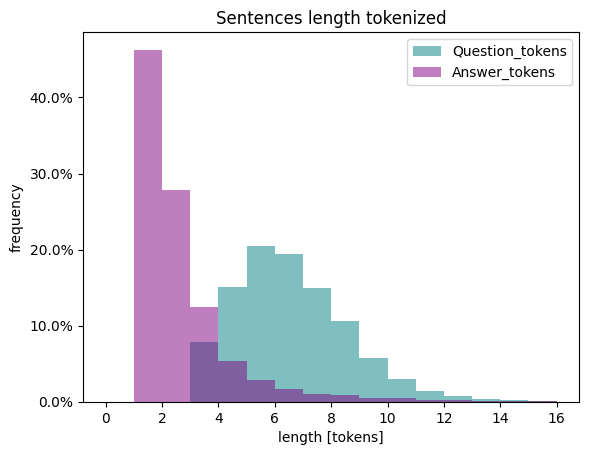

In [66]:
# display the histograms to see if that worked

train_df_final_thresholds = histograms(train_df_final, cols_tokens, name = 'tokenized')

In [67]:
train_df_final.shape

(7891, 4)

In [68]:
# shortest sentences removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.09
	         median: 6.00
	         minimum: 3
	         maximum: 17)
Sentences in column Answer_tokens:
	         mean: 2.16
	         median: 2.00
	         minimum: 1
	         maximum: 17)


In [69]:
test_df_final = filter_sentences(test_df_final, cols_tokens, [2,0], condition='longer')

Question_tokens 3
Answer_tokens 1


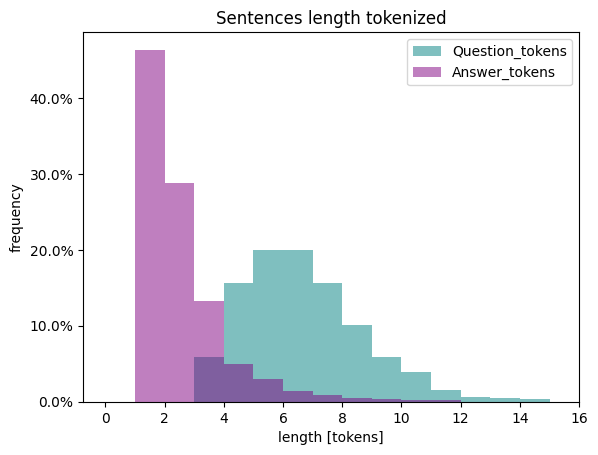

In [70]:
# display the histograms to see if that worked

test_df_final_thresholds = histograms(test_df_final, cols_tokens, name = 'tokenized')

In [71]:
test_df_final.shape

(1615, 4)

In [72]:
# shortest sentences removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.18
	         median: 6.00
	         minimum: 3
	         maximum: 16)
Sentences in column Answer_tokens:
	         mean: 2.07
	         median: 2.00
	         minimum: 1
	         maximum: 13)


### Remove long outliers: long sentences that occure rarely

In [73]:
# keeping only the 95% of the data
cutoff = 95

In [74]:
get_thresholds(train_df_final_thresholds, cutoff = cutoff)

{'Question_tokens': 10, 'Answer_tokens': 6}

In [75]:
Q_MAX, A_MAX = get_thresholds(train_df_final_thresholds, cutoff = cutoff).values()

In [76]:
Q_MAX, A_MAX

(10, 6)

In [77]:
train_df_final = filter_sentences(train_df_final, cols_tokens, [Q_MAX+1,A_MAX+1], condition='shorter')

In [78]:
# long outliers removed
sentences_stats(train_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 5.93
	         median: 6.00
	         minimum: 3
	         maximum: 10)
Sentences in column Answer_tokens:
	         mean: 1.93
	         median: 2.00
	         minimum: 1
	         maximum: 6)


In [50]:
# to simplify I'm using the same thresholds for the test set

In [79]:
test_df_final = filter_sentences(test_df_final, cols_tokens, [Q_MAX+1,A_MAX+1], condition='shorter')

In [80]:
# long outliers removed
sentences_stats(test_df_final, cols_tokens)

Sentences in column Question_tokens:
	         mean: 6.01
	         median: 6.00
	         minimum: 3
	         maximum: 10)
Sentences in column Answer_tokens:
	         mean: 1.91
	         median: 2.00
	         minimum: 1
	         maximum: 6)


In [81]:
train_df_final.shape, test_df_final.shape

((7397, 4), (1529, 4))

### Pairs have to be redone from the cleaned up datasets, to be used in the model (after being turned into tensors).

In [82]:
train_pairs_final = get_pairs_from_df(train_df_final, cols_tokens)

In [83]:
test_pairs_final = get_pairs_from_df(test_df_final, cols_tokens)

In [84]:
len(train_pairs_final), len(test_pairs_final)

(7397, 1529)

### Data preparation for the neural network model

Sequences are converted into torch tokens made of their vocabulary indexes. Sequences shorter than the defined length are padded at the beginning. Also Start-Of-Sequence and End-Of-Sequence tokens are added to the tensor.

The padding token will be ignored by the model.

### Neural network model

It uses Seq2Seq Encoder-Decoder architecture with a single LSTM layer. Right now the training is done pair after pair, without batch processing.
The optimizer is Stochastic Gradient Descent, and the loss function is 
negative log likelihood (NLLLoss)



In [85]:
import torch
import torch.nn as nn

## ENCODER

In [251]:
class Encoder(nn.Module):
    
    # We initialize the Encoder object with appropriate layers

    def __init__(self, input_size, hidden_size, embedding_size):
        
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.embedding_size = embedding_size

        # embedding step
        self.embedding = nn.Embedding(self.input_size, self.embedding_size).to(device)
        
        # single LSTM layer
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, 1).to(device)
    
    def forward(self, x, hidden, cell_state):
        x = self.embedding(x)       
        print(x.shape)
        #x = x.view(1, 1, -1)        
        #print(x.shape)
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        return x, hidden, cell_state

## DECODER

In [252]:
class Decoder(nn.Module):

    # The Decoder is initialized in the same manner.

    def __init__(self, hidden_size, output_size, embedding_size):

        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding_size = embedding_size

        # embedding
        self.embedding = nn.Embedding(self.output_size, self.embedding_size)

        # single LSTM layer
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size)
        
        # fully connected linear layer
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        
        # softmax
        self.softmax = nn.LogSoftmax(dim=1)     

    def forward(self, x, hidden, cell_state):
        
        x = self.embedding(x)
        x = x.view(1, 1, -1)
        x, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))
        x = self.softmax(self.fc(x[0]))
        return x, hidden, cell_state

## SEQ2SEQ

In [318]:
class Seq2Seq(nn.Module):

    def __init__(self, input_size, hidden_size, embedding_size, output_size, device):    

        super(Seq2Seq, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        
        # make encoder and decoder 
        self.encoder = Encoder(self.input_size, self.hidden_size, self.embedding_size).to(device)
        self.decoder = Decoder(self.hidden_size, self.output_size, self.embedding_size).to(device)
                
    def forward(self, src_batch: torch.LongTensor, trg_batch: torch.LongTensor, src_len, trg_len, teacher_forcing_ratio: float = 0.5):
        
        # target batch (answers) is unpacked to maximum length and batch size
        #max_len, batch_size = trg_batch.shape               
        
        batch_size, max_len = trg_batch.shape               
        
        #print(f'Seq len: {max_len}, batch size {batch_size}, src_batch {src_batch.shape}, trg_batch {trg_batch.shape}')

        # WHAT IS THE DIFFERENCE BETWEEN max_len and trg_len here???
        
        trg_vocab_size = self.decoder.output_size
        
        # print(f"trg_vocab_size: {trg_vocab_size}")
        
        # tensor to store decoder's output
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(device) #.to(self.device) 

        # print(f"outputs size (tensor to store decoder's outputs): {outputs.shape}")
        
        print("Batch size", batch_size)
        
         # initialize hidden and cell state
        encoder_hidden = torch.zeros([1, batch_size, self.hidden_size]).to(device) 
        cell_state = torch.zeros([1, batch_size, self.hidden_size]).to(device)

        
        # iterate over the length of the source (question sequence) using the encoder
        
        _, hidden, cell = self.encoder(src_batch.unsqueeze(2), encoder_hidden, cell_state)
        
        '''
        for i in range(src_len):
        
            # last hidden & cell state of the encoder is used as the decoder's initial hidden state
            
            # src_batch[i] is the ith token of the input (question)
            _, hidden, cell = self.encoder(src_batch[i], encoder_hidden, cell_state)
        
        '''
        
        # trg_batch[0] that's just the first element of trg_batch        
        trg = trg_batch[0]
        
        
        # now iterating over the target length, using the decoder
        
        for i in range(trg_len):
            prediction, hidden, cell = self.decoder(trg, hidden, cell)
            
            # here we use the teacher forcing: if the random value is less than the ratio, then the target is just an element of the target (token from the answer)
            # otherwise it's the highest probability prediction
            outputs[i] = prediction
            
            if random.random() < teacher_forcing_ratio:
                trg = trg_batch[i]
            else:
                trg = prediction.argmax(1)
                
        return outputs

### Model parameters

In [319]:
embedding_dim = 256
hidden_size = 256

### Hyperparameters

In [320]:
learning_rate = 0.01
num_epochs = 25

### Model

In [321]:
seq2seq = Seq2Seq(input_size=Q_vocab.n_words, hidden_size=hidden_size, embedding_size=embedding_dim, output_size=A_vocab.n_words, device=device)

In [322]:
seq2seq = seq2seq.to(device)

### Optimizer and loss function

In [323]:
from torch import optim
import torch.nn as nn

In [324]:
#optimizer = optim.SGD(seq2seq.parameters(), lr=learning_rate)
optimizer = optim.Adam(seq2seq.parameters(), lr=learning_rate)
criterion = nn.NLLLoss(ignore_index=0).to(device) # 0 is padding

### Model training 

For debugging purposes the training function is kept in the main notebook for now.

In [325]:
total_train_loss = []
total_test_loss = []

## DATALOADER

I'm creating a very simple Dataset class, that can be then used by the DataLoader.

In [326]:
from torch.utils.data import DataLoader, Dataset

In [327]:
class MyDataset(Dataset):
    def __init__(self, pairs):
        
        '''
        Input: pairs of padded sequences converted to tensors
        '''
        
        self.source_data = [p.question for p in pairs]
        self.target_data = [p.answer for p in pairs]
            
    def __getitem__(self, idx):
        return self.source_data[idx], self.target_data[idx]
    
    def __len__(self):
        return len(self.source_data)

## New pairs creating function

In [328]:
def to_tensor_new(vocab, tokens, seq_len, padding):
    '''Converts a tokenized sentence into a tensor of indices of a given length.
    Allows to choose to pad either at the beginning or at the end.
    Padding at the beginning is the default option.'''
    
    tokens = [t for t in tokens if t in vocab.word2count.keys()]
    
    if padding == 'end':
    
        padded = [[vocab.word2index['SOS']] + [vocab.word2index[t] for t in tokens] + [vocab.word2index['EOS']] + [vocab.word2index['PAD']] * (seq_len-len(tokens))]
        
    else:
    
        padded = [vocab.word2index['PAD']] * (seq_len-len(tokens)) + [vocab.word2index['SOS']] + [vocab.word2index[t] for t in tokens] + [vocab.word2index['EOS']]

    tensor = torch.Tensor(padded).long().view(-1,1).squeeze()
    
    return tensor

In [329]:
Pair = namedtuple('Pair', ['question', 'answer'])
def get_tensor_pairs_from_df(df, cols, q_vocab, q_max_len, a_vocab, a_max_len, padding):
    '''returns a list of named tuples (question, answer)'''
    dicts = []
    for col in cols:
        dicts.append(df[col].to_dict().values())
    
    return [Pair(to_tensor_new(q_vocab, q, q_max_len, padding), to_tensor_new(a_vocab, a, a_max_len, padding)) for q, a in zip(*dicts)]

In [330]:
train_tensor_pairs_final = get_tensor_pairs_from_df(train_df_final, cols_tokens, Q_vocab, Q_MAX, A_vocab, A_MAX, 'end')

In [331]:
test_tensor_pairs_final = get_tensor_pairs_from_df(test_df_final, cols_tokens, Q_vocab, Q_MAX, A_vocab, A_MAX, 'end')

In [332]:
type(train_tensor_pairs_final)

list

In [333]:
train_tensor_pairs_final[0].question.shape

torch.Size([12])

In [334]:
train_dataset = MyDataset(train_tensor_pairs_final)

In [335]:
test_dataset = MyDataset(test_tensor_pairs_final)

In [336]:
BATCH_SIZE = 16

## DataLoader

In [337]:
train_dl = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [338]:
test_dl = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [339]:
def train(model, dataloader, optimizer, criterion, device, teacher_forcing_ratio = 0.5, print_every = 1000): 
    
    model.train() # Set the model to training mode

    total_loss = 0

    count = 0

    for batch in dataloader:

        src_tensor, tgt_tensor = batch # get question and answer tensors from the batch
                
        src_tensor, tgt_tensor = src_tensor.to(device), tgt_tensor.to(device) # move them to the device

        print(src_tensor.shape, tgt_tensor.shape)
        
        src_tensor = src_tensor.view(-1,1)
        
        # src_tensor, tgt_tensor = src_tensor.reshape(-1,1), tgt_tensor.reshape(-1,1) # reshape to a two-dimensional tensor to feed the Seq2Seq class
                
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        output = model(src_tensor, tgt_tensor, src_len=src_tensor.size(0), trg_len=tgt_tensor.size(0), teacher_forcing_ratio=teacher_forcing_ratio)

        # Compute the loss
        loss = criterion(output.view(-1, output.size(-1)), tgt_tensor.view(-1))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        count += 1 

        if count % print_every == 0:
            print(f'Loss {total_loss/count}')

    return total_loss / len(dataloader)

In [340]:
def evaluate(model, dataloader, criterion, device):
    
    model.eval()
    
    total_loss = 0
    
    with torch.no_grad():
        
        for batch in dataloader:

            src_tensor, tgt_tensor = batch

            src_tensor, tgt_tensor = src_tensor.to(device), tgt_tensor.to(device)

            # src_tensor, tgt_tensor = src_tensor.reshape(-1,1), tgt_tensor.reshape(-1,1)

            output = model(src_tensor, tgt_tensor, src_len=src_tensor.size(0), trg_len=tgt_tensor.size(0), teacher_forcing_ratio=0) # turn off teacher forcing

            # Compute the loss
            loss = criterion(output.view(-1, output.size(-1)), tgt_tensor.view(-1))
            
            total_loss += loss.item()
        
    return total_loss / len(dataloader)

In [341]:
import matplotlib.pyplot as plt

In [342]:
for epoch in range(num_epochs):
    train_loss = train(seq2seq, train_dl, optimizer, criterion, device)
    test_loss = evaluate(seq2seq, test_dl, criterion, device)    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    
    total_train_loss.append(train_loss)
    total_test_loss.append(test_loss)



torch.Size([16, 12]) torch.Size([16, 8])
Batch size 16
torch.Size([192, 1, 1, 256])


RuntimeError: For unbatched 2-D input, hx and cx should also be 2-D but got (3-D, 3-D) tensors

# STOPPING AFTER 10 EPOCHS - NOT CONVERGING

In [100]:
N_EPOCHS = 10

Text(0, 0.5, 'loss')

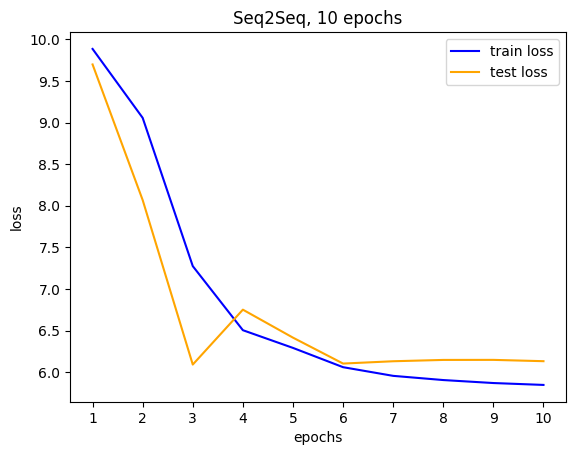

In [101]:
fig, ax = plt.subplots()
ax.plot(range(1, N_EPOCHS+1), total_train_loss, color = 'blue', label = 'train loss')
ax.plot(range(1, N_EPOCHS+1), total_test_loss, color = 'orange', label = 'test loss')
ax.legend()
ax.set_title(f'Seq2Seq, {N_EPOCHS} epochs')
ax.set_xticks(range(1, N_EPOCHS+1))
ax.set_xlabel('epochs')
ax.set_ylabel('loss')